<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/SVM_Baseline_Model_fromRachael.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
# Import the libraries we'll use below.
import numpy as np
import pandas
import glob
import os
import skimage.io as io

import math 
from matplotlib import pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
import seaborn as sns
from IPython.display import Image
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
import statsmodels.api as sm

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importing SVM model
from sklearn import svm
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.model_selection import GridSearchCV
import sklearn.metrics

# Mounting Google Drive to Access Data

In [ ]:
# Mount the Google Drive Folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Pulling all the files from each subfolder

files= list(glob.glob("/content/drive/MyDrive/DATASCI W207 - Machine Learning/Dataset/*"))

files

['/content/drive/MyDrive/DATASCI W207 - Machine Learning/Dataset/Train',
 '/content/drive/MyDrive/DATASCI W207 - Machine Learning/Dataset/Test',
 '/content/drive/MyDrive/DATASCI W207 - Machine Learning/Dataset/Validate']

In [ ]:
# Samples of images is a list, taking the file path and going into each slide/folder
samples = [glob.glob(files[i]+'/*/*')for i in range(0, len(files))]
samples

In [ ]:
# Index will need to be adjusted based on how many subfolders there are on the group project

x=[]
y=[]

for i in range(0, len(samples)):
    for j in range(0, len(samples[i])):
        x.append(samples[i][j])
        y.append(samples[i][j].split('/')[7])

## Creating a DF of the Train, Test and Validate paths

In [ ]:
d = {"patches":x,"IDC":y}

In [ ]:
data = pd.DataFrame(data=d)
data # path to image, IDC value

# Pulling out the Train Set, as a DF

In [ ]:
train_DF = data[data['patches'].str.contains('Train')]

train_DF

# train_DF.info()

# Randomize data NOT NEEDED ANYMORE

In [ ]:


indexes = np.arange(df_features.shape[0])
print('indexes:', indexes)

np.random.seed(0)    # get the same results each time    ??????
shuffled_indexes = np.random.permutation(indexes)
print('shuffled indexes:', shuffled_indexes, '\n')

# change the ordering of the original df_features using .reindex()
df_features = df_features.reindex(shuffled_indexes)
display(df_features)

# Baseline - SVM Model 

## 1. Taking inputs 

In [ ]:
# 1.Taking inputs  try 2

from tqdm import tqdm # import tqdm

# Apply gray scale to all images, flatten and store array / shape in new columns
def get_img_arrays(df,):
    # read each image array from corresponding path as grayscale and flatten the image array
    df['img_array'] = df.progress_apply(lambda x : io.imread(x['patches'],as_gray=True).flatten(),axis=1) # make sure to specify axis = 1
    # get the shape of each image array and store it in the dataframe
    df['array_shape'] = df.progress_apply(lambda x : x['img_array'].shape[0],axis=1) # make sure to specify axis = 1
    return df


In [ ]:
# Running the function

from tqdm import tqdm # import tqdm
tqdm.pandas() # initialize tqdm for pandas

# # tqdm is a library that enables you to visualize the progress of a for loop by displaying a configurable progress bar

flat_data_full = get_img_arrays(df = data)

# img_array column now stores values between 0 and 1 

100%|██████████| 1193/1193 [00:00<00:00, 73710.02it/s]


In [ ]:
flat_data_full

In [ ]:
"""
Checking the Array Shapes
As expected most of our image arrays have a length of 2500, this is because our arrays where originally, 50 x 50 x 3 so when we convert them to grayscale we get an array of 50 x 50 x 1
when we flatten it we get 2500 total values.
"""

flat_data_full.array_shape.value_counts()


2500    1193
1550       1
1400       1
1350       1
1150       1
1650       1
2250       1
350        1
Name: array_shape, dtype: int64

In [ ]:
# to make the model better, we would drop images with the wrong size (not 2500)

weird_imgs = flat_data_full[flat_data_full['array_shape'] != 2500] 
weird_imgs

# 7 files are dropped

# drop images using indices of the filter
flat_data_full.drop(weird_imgs.index,inplace=True)

flat_data_full

In [ ]:
# Shuffle the full dataset before splitting

from sklearn.utils import shuffle

flat_data_full = shuffle(flat_data_full)

flat_data_full

# Pull out training set and populate arrays

In [ ]:
# Create a TRAINING SET FROM PREPROCESSED IMAGES

# Pull out the ~800 train images
train_df = flat_data_full[flat_data_full['patches'].str.contains('/Train/')]

# get the number of rows in the pandas dataframe in order to determine the number of rows in our numpy array
nrows=train_df.shape[0]

ncols = 2500

img_arrays_train = np.zeros((nrows,ncols))
print(img_arrays_train.shape) #797 rows, 2500 is the size of the array)

(797, 2500)


In [ ]:
# TRAINING SET --> add all the image arrays to the numpy array that we just initialized

for i,array in enumerate(train_df['img_array']):
    img_arrays_train[i,:] = array

display(img_arrays_train[0:5,:])

array([[0.9282502 , 0.92518471, 0.92349529, ..., 0.58064275, 0.62721922,
        0.62554471],
       [0.74075647, 0.78556039, 0.70387451, ..., 0.66587294, 0.61151373,
        0.78054549],
       [0.51218078, 0.4183451 , 0.5256498 , ..., 0.44824353, 0.55391137,
        0.4612302 ],
       [0.3162102 , 0.25915922, 0.32808078, ..., 0.93694941, 0.91200549,
        0.90975843],
       [0.56029961, 0.4965549 , 0.47690235, ..., 0.41985412, 0.63706078,
        0.75785725]])

In [ ]:
# TRAINING SET --> Extract Variables of interest and store them in a new dataframe
# dfd 

train_inputs = train_df.loc[:,['img_array','IDC']]
# df_inputs.head()

train_inputs.head()

,img_array,IDC
235,"[0.9282501960784313, 0.9251847058823528, 0.923...",1
240,"[0.7407564705882353, 0.7855603921568627, 0.703...",1
180,"[0.5121807843137255, 0.4183450980392157, 0.525...",1
594,"[0.31621019607843137, 0.2591592156862745, 0.32...",0
146,"[0.5602996078431373, 0.49655490196078433, 0.47...",1


# Pull out Test Set and create arrays

In [ ]:
# Create a TEST SET FROM PREPROCESSED IMAGES

# Pull out the ~200 train images
test_df = flat_data_full[flat_data_full['patches'].str.contains('/Test/')]

# get the number of rows in the pandas dataframe in order to determine the number of rows in our numpy array
nrows=test_df.shape[0]

ncols = 2500

img_arrays_test = np.zeros((nrows,ncols))
print(img_arrays_test.shape) #199 rows, 2500 is the size of the array)

(199, 2500)


In [ ]:
# TEST SET --> add all the image arrays to the numpy array that we just initialized

for i,array in enumerate(test_df['img_array']):
    img_arrays_test[i,:] = array

display(img_arrays_test[0:5,:])

array([[0.44356549, 0.41293176, 0.58385961, ..., 0.53854   , 0.38480745,
        0.35906863],
       [0.49764824, 0.48789333, 0.57400588, ..., 0.51444706, 0.55449608,
        0.44555529],
       [0.52896039, 0.76406353, 0.46456353, ..., 0.51347373, 0.64442863,
        0.46153569],
       [0.7009902 , 0.73042824, 0.56077059, ..., 0.91762431, 0.77524   ,
        0.65227255],
       [0.67071451, 0.65751333, 0.60227529, ..., 0.69370118, 0.62049216,
        0.61906275]])

In [ ]:
# TEST SET --> Extract Variables of interest and store them in a new dataframe
# dfd 

test_inputs = test_df.loc[:,['img_array','IDC']]

test_inputs.head()

,img_array,IDC
848,"[0.44356549019607844, 0.41293176470588233, 0.5...",1
837,"[0.4976482352941176, 0.4878933333333334, 0.574...",1
876,"[0.5289603921568627, 0.7640635294117648, 0.464...",1
869,"[0.7009901960784313, 0.7304282352941176, 0.560...",1
990,"[0.6707145098039216, 0.6575133333333334, 0.602...",0


# Separate Train and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split
# split our data into training and testing data, and input data and target data

# Training
X_train = img_arrays_train
y_train = train_inputs['IDC']

# Testing
X_test = img_arrays_test
y_test = test_inputs['IDC']

# compare the shape of the train and test inputs
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')



X_train Shape: (797, 2500)
X_test Shape: (199, 2500)
y_train Shape: (797,)
y_test Shape: (199,)


## 2. Model Construction with GridSearch

### We will use GridSearch to Optimize the Hyperparameters

In [ ]:
#2. Model construction

# Giving the model a parameter grid for hyperparameter tuning
param_grid= {'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['linear','rbf','poly']}


# Create a support vector classifier: 
svc=svm.SVC() # Question: are we not defining the kernel purposely here..I was reading we have to define if it is linear, poly or rbf (maybe rbf since pictures?)

# With the help of GridSearchCV and parameters grid, create a model:

model=GridSearchCV(svc,param_grid)


## 3. Model Training (fitting)

In [ ]:
model.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']})

## 4. Model Testing (Predict)

In [ ]:
# Accuracy for the Training set
# Accuracy/Score is: total correctly classified / total number of classifications

print("Accuracy for the Train set is: ", model.score(X_train,y_train))

Accuracy for the Train set is:  0.7728983688833124


In [ ]:
# Accuracy for the Testing set
print("Accuracy for the Test set is: ", model.score(X_test,y_test))

Accuracy for the Test set is:  0.7185929648241206


## 5. Model Evaluation

### First, we will see which paramaters created the best model

From Tatiana - 
Think this is a good approach my research shows the same and here is sample code for a grid search
One thing I saw in my research was how we code this depends on the type of Kernel we want to use linear, polynomial, or radial basis function (rbf)
 For RBF we need to include C parameters and gamma parameters


Linked: https://towardsdatascience.com/svm-support-vector-machine-for-classification-710a009f6873
code I got from online:
      # from sklearn.model_selection import GridSearchCV
      # param = {'C':(0,0.01,0.5,0.1,1,2,5,10,50,100,500,1000)}
      # svm1 = svm.SVC(kernel = 'linear')
      # svm.grid = GridSearchCV(svm1,param,n_jobs=1,cv=10,verbose=1,scoring='accuracy')
      #svm.grid.fit(X_train,y_train)


In [ ]:
# Examine the best model, paramaters, precision, recall

# Best score achieved during the GridSearchCV
print('\nGridSearch CV best Score : {:.4f}'.format(model.best_score_))

# Best parameters with GridSearchCV
print('\nGridSearch CV best Parameters :',model.best_params_)

# print Estimator that was chosen by the GridSearch
print('\nEstimator that was chosen by the search :', (model.best_estimator_))

# Model Precision: what percentage of positive tuples are labeled as such?
# print("\nPrecision:",model.sklearn.metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
# print("\nRecall:",model.recall_score(y_test, y_pred))



GridSearch CV best Score : 0.7515

GridSearch CV best Parameters : {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

Estimator that was chosen by the search : SVC(C=10, gamma=0.0001)


In [ ]:
y_pred = model.predict(X_test)

print(y_pred)

y_true = np.array(y_test)

print("**************")

print(y_true)


['1' '1' '1' '1' '1' '1' '0' '0' '1' '1' '0' '1' '1' '0' '1' '0' '1' '1'
 '1' '0' '1' '1' '0' '0' '1' '1' '0' '1' '1' '0' '0' '1' '0' '1' '0' '1'
 '0' '1' '0' '0' '1' '0' '1' '0' '1' '1' '0' '1' '0' '1' '1' '1' '1' '0'
 '1' '0' '1' '0' '1' '1' '1' '1' '1' '0' '0' '0' '1' '1' '0' '0' '1' '1'
 '1' '0' '1' '0' '0' '0' '0' '1' '1' '1' '0' '1' '0' '0' '1' '0' '0' '1'
 '1' '1' '1' '1' '1' '1' '0' '1' '1' '1' '1' '1' '1' '1' '1' '0' '0' '1'
 '0' '1' '1' '0' '0' '1' '1' '0' '1' '0' '1' '0' '0' '1' '1' '0' '0' '1'
 '1' '0' '1' '1' '0' '0' '0' '1' '0' '0' '1' '0' '0' '1' '0' '0' '0' '1'
 '1' '0' '0' '0' '0' '1' '0' '1' '1' '1' '0' '1' '0' '1' '1' '1' '1' '0'
 '0' '1' '0' '1' '0' '0' '0' '1' '1' '1' '1' '1' '0' '0' '1' '1' '1' '1'
 '1' '1' '0' '1' '1' '0' '0' '1' '1' '1' '1' '0' '1' '0' '0' '0' '0' '0'
 '1']
**************
['1' '1' '1' '1' '0' '1' '0' '0' '1' '1' '0' '1' '1' '1' '1' '1' '1' '0'
 '0' '1' '1' '1' '0' '0' '1' '1' '0' '1' '1' '0' '0' '1' '1' '1' '1' '0'
 '0' '1' '0' '0' '1' '0' '1' '

In [ ]:
print(sklearn.metrics.classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.65      0.70        99
           1       0.69      0.79      0.74       100

    accuracy                           0.72       199
   macro avg       0.72      0.72      0.72       199
weighted avg       0.72      0.72      0.72       199



### Then, for this optimized model, we will check overfitting/underfitting

In [ ]:
#5. Model evaluation

# Using ROC Curve, we are measuring the classification model performance visually
# Is it close to 1? 





### Next, we will analyze the Confusion Matrix 

In [ ]:
# Create a confusion matrix & plot
# From scikit learn 

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true=y_test,y_pred=model.predict(X_test)).ravel()

print(f'training set: true negatives: {tn}')
print(f'training set: true positives: {tp}')
print(f'training set: false negatives: {fn}')
print(f'training set: false positives: {fp}')


training set: true negatives: 64
training set: true positives: 79
training set: false negatives: 21
training set: false positives: 35


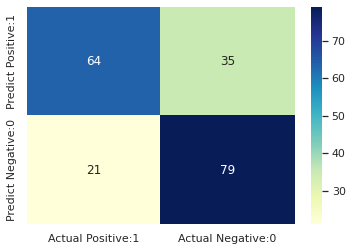

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm = confusion_matrix(y_true, y_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')